# Fine-Tuning Bert for text Classification - PROTOTYPING
## ECHR Violation Prediction
Following the tutorial of [huggingface](https://huggingface.co/docs/transformers/tasks/sequence_classification)

In [1]:
#%pip install transformers datasets evaluate seaborn scikit-learn prettyprinter

In [2]:
#%pip install accelerate -U

In [3]:
#local variable 
model_name = 'distilbert-base-uncased' # distilbert-base-uncased # legal bert 
path = 'proto/distilbert/3e-6_16_10'

### Load the prorotyping subset of the dataset.

In [4]:
import pandas as pd

df_train = pd.read_csv('ECHR_Dataset_Sub/EN_train_sub.csv')
df_dev = pd.read_csv('ECHR_Dataset_Sub/EN_dev_sub.csv')
#df_test = pd.read_csv('ECHR_Dataset_Sub/EN_test_sub.csv')

In [5]:
print(df_train[['VIOLATED_ARTICLES']])

    VIOLATED_ARTICLES
0         ['13', '6']
1               ['3']
2               ['6']
3         ['10', '6']
4    ['13', '3', '5']
..                ...
195                []
196                []
197                []
198                []
199                []

[200 rows x 1 columns]


In [6]:
# print VIOLATED_ARTICLES and labels
print(df_train[['VIOLATED_ARTICLES', 'LABEL']].sample(10))

          VIOLATED_ARTICLES  LABEL
196                      []      0
118                      []      0
138                      []      0
92              ['6', 'P1']      1
78              ['13', '6']      1
82                    ['8']      1
45   ['13', '2', '38', '5']      1
124                      []      0
55                    ['6']      1
75                    ['6']      1


### Prepare Dataset: use just text and label columns

In [7]:
# remove all columns except text and label
df_train = df_train[['TEXT', 'LABEL']]
df_dev = df_dev[['TEXT', 'LABEL']]
#df_test = df_test[['TEXT', 'LABEL']]

print(df_train.head())

                                                TEXT  LABEL
0  4. The applicant was born in 1938 and lives in...      1
1  6. The applicants were born in 1983 and 1981 r...      1
2  5. The applicant was born in 1949 and lives in...      1
3  8. The applicant is a Turkish citizen who was ...      1
4  6. The applicant was born in 1965 and is servi...      1


In [8]:
print(type(df_train['TEXT'][0]))
df_train['TEXT'][0]

<class 'str'>


'4. The applicant was born in 1938 and lives in Jelsa. 5. The applicant’s mother died on 1 May 1994 and inheritance proceedings were opened before the Stari Grad Municipal Court (Općinski sud u Starom Gradu). 6. On 8 June 1999 the court issued a decision distributing the property between the applicant and his brother. The relevant part of that decision reads: ... the land registry division of this court shall register the ownership of the heirs [listed above], once [that part of the decision] becomes final... 7. Subsequently, the applicant’s brother lodged an appeal against that decision complaining about the ruling on the costs of the proceedings. 8. On 12 April 2002 the Split County Court (Županijski sud u Splitu) declared the appeal inadmissible. The decision was served on the applicant’s representative on 22 May 2002. 9. It would appear that the applicant’s ownership of the inherited property has to date not been recorded in the land register.'

In [9]:
# change name TEXT to text and LABEL to label
df_train.rename(columns={'TEXT': 'text', 'LABEL': 'label'}, inplace=True)
df_dev.rename(columns={'TEXT': 'text', 'LABEL': 'label'}, inplace=True)
#df_test.rename(columns={'TEXT': 'text', 'LABEL': 'label'}, inplace=True)

### Encode the text using Tokenizer pretrained form BERT

In [10]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name)

In [11]:
def preprocess_function(examples):
    return tokenizer(examples["text"])

In [12]:
# df_train from pandas dataframe to huggingface dataset format
from datasets import Dataset
train_dataset = Dataset.from_pandas(df_train)
train_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 200
})

In [13]:
train_dataset_tokenized = train_dataset.map(preprocess_function, batched= True)

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (3356 > 512). Running this sequence through the model will result in indexing errors


In [14]:
print(train_dataset_tokenized)
print(train_dataset_tokenized[0]['input_ids'].__len__())

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 200
})
214


In [15]:
# do the same for df_dev
dev_dataset = Dataset.from_pandas(df_dev)
dev_dataset_tokenized = dev_dataset.map(preprocess_function, batched=True)
print(dev_dataset_tokenized[0]['input_ids'].__len__())
dev_dataset_tokenized


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

1492


Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 200
})

In [16]:
type(dev_dataset_tokenized[0]['input_ids'])

list

### Instead of truncate to first 512, try to undarstand the best way to use the whole text.

In [17]:
def head_tail_tokens(dataset, head:int, tail:int):

    # from dataset transformers to dataframe pandas
    df = pd.DataFrame(dataset)

    # slice each input_ids value  only if head + tail < len(input_ids)
    df['input_ids'] = df['input_ids'].apply(lambda x: x[:head] + x[-tail:] if len(x) > head + tail else x)
     # do the same for attention_mask
    df['attention_mask'] = df['attention_mask'].apply(lambda x: x[:head] + x[-tail:] if len(x) > head + tail else x)
    if model_name != 'distilbert-base-uncased':
        df['token_type_ids'] = df['token_type_ids'].apply(lambda x: x[:head] + x[-tail:] if len(x) > head + tail else x)


    # convert back to dataset transformers
    dataset = Dataset.from_pandas(df)

    return dataset

In [18]:
train_head_tail = head_tail_tokens(train_dataset_tokenized, 256,256)
print(train_head_tail[1]['input_ids'].__len__())

dev_head_tail = head_tail_tokens(dev_dataset_tokenized, 256,256)
print(dev_head_tail[1]['input_ids'].__len__())

512
512


### Define model, metrics and training parameters.

In [19]:
# batch
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt", padding=True)

In [20]:
# evaluate
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [21]:
# labels
id2label = {0: 'negative', 1: 'positive'}
label2id = {'negative': 0, 'positive': 1}

In [22]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    id2label=id2label,
    label2id=label2id
    )

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir=path,          # output directory
    learning_rate=3e-6,              # learning rate
    num_train_epochs=10,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    weight_decay=0.01,               # strength of weight decay
    logging_dir=path+'/log',    # directory for storing logs
    logging_steps=13,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model = 'eval_loss',
    seed = 42
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_head_tail,         # training dataset
    eval_dataset=dev_head_tail,            # evaluation dataset
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
    tokenizer=tokenizer,
    data_collator=data_collator
)


### Train

In [24]:
trainer.train()

/opt/conda/envs/sagemaker-distribution/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.696400,0.688452,0.570000
2,0.683000,0.685265,0.645000
3,0.679700,0.682035,0.660000
4,0.667600,0.677363,0.675000
5,0.664800,0.671681,0.685000
6,0.657300,0.664389,0.715000
7,0.633200,0.656055,0.695000
8,0.617100,0.647992,0.690000
9,0.605000,0.642185,0.700000
10,0.595200,0.640324,0.700000


TrainOutput(global_step=130, training_loss=0.6475173876835749, metrics={'train_runtime': 134.4257, 'train_samples_per_second': 14.878, 'train_steps_per_second': 0.967, 'total_flos': 264934797312000.0, 'train_loss': 0.6475173876835749, 'epoch': 10.0})

In [25]:
trainer.save_model(path+'/model')

In [44]:
import json
with open(path+'/log.txt','w') as fout:
    json.dump(trainer.state.log_history,fout)
    

### Model Metrics on Validation Set 

In [28]:
# load trained model
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(path+"/model")

In [29]:
from transformers import TrainingArguments, Trainer

training_args_val = TrainingArguments(
    output_dir=path,          # output directory
    logging_dir=path+'/log',    # directory for storing logs
    logging_steps=10,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    save_total_limit=4,
    load_best_model_at_end=True,
    metric_for_best_model = 'eval_loss',
    seed = 42
)

trainer_val = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_head_tail,         # training dataset
    eval_dataset=dev_head_tail,            # evaluation dataset
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
    tokenizer=tokenizer,
    data_collator=data_collator
)


{   '0': {   'f1-score': 0.5714285714285715,
             'precision': 1.0,
             'recall': 0.4,
             'support': 100.0},
    '1': {   'f1-score': 0.7692307692307693,
             'precision': 0.625,
             'recall': 1.0,
             'support': 100.0},
    'accuracy': 0.7,
    'eval_loss': 0.6403239369392395,
    'macro avg': {   'f1-score': 0.6703296703296704,
                     'precision': 0.8125,
                     'recall': 0.7,
                     'support': 200.0},
    'weighted avg': {   'f1-score': 0.6703296703296704,
                        'precision': 0.8125,
                        'recall': 0.7,
                        'support': 200.0}}


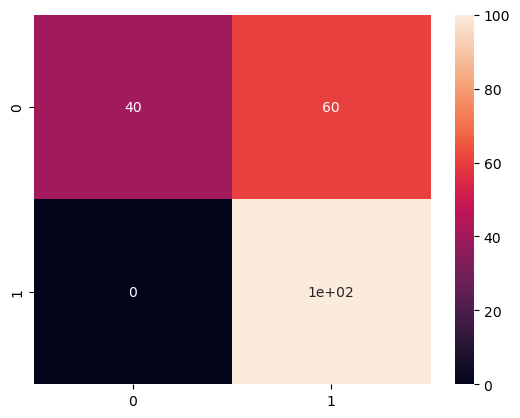

In [30]:
output = trainer_val.predict(dev_head_tail)
output[2]

eval_loss = trainer_val.evaluate()['eval_loss']

import pandas
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pprint

predicted_labels = [ logits.argmax().item() for logits in output[0] ]
labels = dev_head_tail['label']

class_report = classification_report(labels, predicted_labels, output_dict = True)
class_report['eval_loss'] = eval_loss
df_report = pandas.DataFrame(class_report).transpose()
df_report.to_csv(path+'/val_report.csv')

pp = pprint.PrettyPrinter(indent=4)
pp.pprint(class_report)
cm = confusion_matrix(labels,predicted_labels)
hm = sns.heatmap(cm, annot=True)
figure = hm.get_figure()    
figure.savefig(path+'/val_conf_matrix.png', dpi=400)

### Evaluate the model on the test set
Following the golden rule, only the final model will be evaluate on test set.

In [31]:
# load trained model
#from transformers import AutoModelForSequenceClassification
#model = AutoModelForSequenceClassification.from_pretrained(path+"/model")

In [32]:
#from transformers import AutoTokenizer
#tokenizer_echr = AutoTokenizer.from_pretrained(path+"/model")
# tokenize function for test 
#def preprocess_echr(examples):
#    return tokenizer_echr(examples["text"])

In [33]:
#from datasets import Dataset
# encode test dataset with trained model
#test_dataset = Dataset.from_pandas(df_test)
#print(test_dataset)

#test_dataset = Dataset.from_pandas(df_test)
#test_dataset_tokenized = test_dataset.map(preprocess_echr, batched=True)


In [34]:
#test_head_tail = head_tail_tokens(test_dataset_tokenized, 250,250)
#print(test_head_tail[1]['input_ids'].__len__())

In [35]:
#output = trainer.predict(test_head_tail)
#output[2]

In [36]:
#from src.utils import metrics_model
#predicted_labels,labels = metrics_model(test_head_tail, model)

In [37]:
#from sklearn.metrics import classification_report, confusion_matrix
#import seaborn as sns
#import pprint

#predicted_labels = [ logits.argmax().item() for logits in output[0] ]
#labels = test_head_tail['label']

#class_report = classification_report(labels, predicted_labels, output_dict = True)
#df_report = pandas.Dataframe(class_report).transpose()
#df_report.to_csv('proto/bert/5e-5_16_10/report')

#pp = pprint.PrettyPrinter(indent=4)
#pp.print(class_rep)
#cm = confusion_matrix(labels,predicted_labels)
#hm = sns.heatmap(cm, annot=True)
#figure = hm.get_figure()    
#figure.savefig('proto/bert/5e-5_16_10/conf_matrix.png', dpi=400)